In [1]:
%matplotlib inline
from validphys.api import API
import numpy as np
import pandas as pd

# fitname = "240108-01-rs-ht-tcm-disonly" # ht_coeff = 2.5
# fitname = "240109-01-rs-ht-tcm-disonly" # ht_coeff = 1.0 | -0.02256 ± 0.02550
# fitname = "240109-02-rs-ht-tcm-disonly" # ht_coeff = 1.0, iterated | -0.03457 ± 0.02597
# fitname = "240109-03-rs-ht-tcm-disonly" # ht_coeff = 2.5, iterated | 0.61057 ± 0.02822

# fitname = "240109-04-rs-ht-tcm-disonly" # 240109-02-rs-ht-tcm-disonly with lowered cuts | 0.21670 ± 0.01147
# fitname = "240110-01-rs-ht-tcm-disonly" # 240109-02-rs-ht-tcm-disonly with highered cuts | 0.05157 ± 0.07621

# fitname = "240112-01-ak-ht-tcm-disonly" # ht_coeff = 1.0 | n. replicas = 500 | -0.02534 ± 0.02577
# fitname = "240122-02-ak-ht-tcm-disonly" # ht_coeff = 1.2 | n. replicas = 500 |  0.00798 ± 0.02604
# fitname = "240122-03-ak-ht-tcm-disonly" # ht_coeff = 1.5 | n. replicas = 500 |  0.07592 ± 0.02578 
# fitname = "240122-04-ak-ht-tcm-disonly" # ht_coeff = 1.7 | n. replicas = 500 |  0.14147 ± 0.02690 
# fitname = "240122-05-ak-ht-tcm-disonly" # ht_coeff = 2.0 | n. replicas = 500 |  0.28917 ± 0.02722 
# Comments: 
#  - The uncertainty seems to be independent on the prior (but might depend on the cuts and the number of replicas).
#  - The central values is unstable, and should not depend on the the prior, whereas it does.

# fitname = "240129-01-ak-ht-tcm-disonly" # ht_coeff = 1.0 | n. replicas = 400 | 0.41233 ± 0.00744 lowered cuts (1, 1)
# fitname = "240129-02-ak-ht-tcm-disonly" # ht_coeff = 1.0 | n. replicas = 500 | 0.21803 ± 0.01103 lowered cuts (1.49, 6.5)
# fitname = "240129-03-ak-ht-tcm-disonly" # ht_coeff = 1.0 | n. replicas = 500 | 0.38203 ± 0.13429 risen cuts (20,60)


# fitname = "240205-01-ach-ht-tcm-disonly"  #    (10, 1)     | h1 = 6.33299 ± 0.05363  h2 = 0.63330 ± 0.00536 std cuts
# fitname = "240205-02-ach-ht-tcm-disonly"  #    (10, 1) |     | h1 = 7.49233 ± 0.01588  h2 = 0.74923 ± 0.00159 low cuts (1,1)
# fitname = "240205-03-ach-ht-tcm-disonly"  #    (10, 1) |     | h1 = 1.82355 ± 0.162934  h2 = 0.18235 ± 0.01629 high cuts (20, 60)
# fitname = "240206-01-ach-ht-tcm-disonly"  #    (1, 10) |     | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688 std cuts
# fitname = "240206-02-ach-ht-tcm-disonly"  #    (1, 10) |     | h1 = 0.60335 ± 0.00457  h2 = 6.03352 ± 0.04567 low cuts (1, 1)
# fitname = "240206-03-ach-ht-tcm-disonly"  #    (1, 10) |     | h1 = 0.17730 ± 0.04032  h2 = 1.77300 ± 0.40317 high cuts (20, 60)
# fitname = "240208-03-ach-ht-tcm-disonly"  #    (1, 10) |     | h1 = 0.16821 ± 0.01151  h2 = 1.68213 ± 0.11506 high cuts (5, 20)
# fitname = "240208-04-ach-ht-tcm-disonly"  #    (10, 1) |     | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688 high cuts (20, 60)

fitnames = {}
#fitnames["fitname_1"]  = "240220-01-ach-ht-tcm"  #   (10, 10)  | std. cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_2"]  = "240220-02-ach-ht-tcm"  #   (10, 10)  | low cuts  | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_3"]  = "240220-03-ach-ht-tcm"  #   (10, 10)  | high cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_4"]  = "240220-04-ach-ht-tcm"  #   (1, 10)   | std. cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_5"]  = "240220-05-ach-ht-tcm"  #   (1, 10)   | low cuts  | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_6"]  = "240220-06-ach-ht-tcm"  #   (1, 10)   | high cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_7"]  = "240220-07-ach-ht-tcm"  #   (10, 1)   | std. cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_8"]  = "240220-08-ach-ht-tcm"  #   (10, 1)   | low cuts  | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_9"]  = "240220-09-ach-ht-tcm"  #   (10, 1)   | high cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_10"] = "240220-10-ach-ht-tcm"  #   (1, 1)    | std. cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_11"] = "240220-11-ach-ht-tcm"  #   (1, 1)    | low cuts  | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688
#fitnames["fitname_12"] = "240220-12-ach-ht-tcm"  #   (1, 1)    | high cuts | h1 = 0.33709 ± 0.00869  h2 = 3.37087 ± 0.08688

In [2]:
fitname = "240308-02-ach-ht-5pt-low"
thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]

if "ht_version" in thcovmat_dict:
    version = thcovmat_dict["ht_version"]
else:
    version = 1

In [3]:
if version == 1:
    ht_coeff = thcovmat_dict["ht_coeff"]
elif version == 2 or version == 3:
    ht_coeff_1 = thcovmat_dict["ht_coeff_1"]
    ht_coeff_2 = thcovmat_dict["ht_coeff_2"]

# dict used to produce theory predictions to construct the theory covmat as well as to produce
# theory predictions from the fit performed using the ht covmat (i.e. the predicitons that should
# be compared to data)
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

In [7]:
# collect the information (predictions + kinematics) needed for the computation of the HT covmat

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)
preds_ht_cov_construction = API.group_result_table_no_table(**(S_dict | common_dict))
preds_ht = pd.DataFrame(preds_ht_cov_construction['theory_central'])

# collect the corresponding kinemacs
process_info = API.combine_by_type_ht(**(S_dict | common_dict))
N_full_data = np.sum([i for i in process_info.sizes.values()])
kinematics_DIS = np.concatenate([v for v in [process_info.data["DIS NC"], process_info.data["DIS CC"]]]).T
# TO CHECK: IS preds[][1] THE THEORY PREDICTION?
preds_DIS = np.concatenate([v for v in [process_info.preds["DIS NC"][1], process_info.preds["DIS CC"][1]]]).T
xvals_DIS = kinematics_DIS[0]
q2vals_DIS = kinematics_DIS[1]

In [ ]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

In [ ]:
# compute the matrix X encoding the PDF uncertainties of the predictions
preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

X = np.zeros((preds.shape[0], preds.shape[0]))
for i in range(preds_onlyreplicas.shape[1]):
    X += np.outer(
        (preds_onlyreplicas[:, i] - mean_prediction), (preds_onlyreplicas[:, i] - mean_prediction)
    )
X *= 1 / preds_onlyreplicas.shape[1]

In [ ]:

# compute the delta of the theory prediction
if version == 1:
    preds_ht["higher twist"] = 0
    preds_ht.loc[['DIS NC', 'DIS CC'],'higher twist'] = ht_coeff * (
        preds_ht.loc[['DIS NC', 'DIS CC'], 'theory_central'] / q2vals_DIS/ (1 - xvals_DIS)
    )
elif version == 2:
    preds_ht["higher twist"] = 0
    preds_ht.loc[['DIS NC', 'DIS CC'],'higher twist'] = preds_ht.loc[['DIS NC', 'DIS CC'], 'theory_central'] * ( 
         ht_coeff_1 + ht_coeff_2 * xvals_DIS / (1 - xvals_DIS)
    ) / q2vals_DIS
elif version == 3:
    preds_ht["higher twist (±,0)"] = 0
    preds_ht["higher twist (0,±)"] = 0
    # Compute beta for shift (±,0)
    preds_ht.loc[['DIS NC', 'DIS CC'],'higher twist (±,0)'] = preds_ht.loc[['DIS NC', 'DIS CC'], 'theory_central'] * (
        ht_coeff_1 / q2vals_DIS
    )
    preds_ht.loc[['DIS NC', 'DIS CC'],'higher twist (0,±)'] = preds_ht.loc[['DIS NC', 'DIS CC'], 'theory_central'] * (
        ht_coeff_2 * xvals_DIS / (1 - xvals_DIS) / q2vals_DIS
        )

#delta_pred = preds_ht['higher twist']
delta_pred = []

if version == 1 or version == 2:
    delta_pred.append(preds_ht['higher twist'])
elif version == 3:
    delta_pred.append(preds_ht['higher twist (±,0)'])
    delta_pred.append(preds_ht['higher twist (0,±)'])

In [ ]:
# Theory covariance matrix
S = np.zeros((delta_pred[0].size, delta_pred[0].size))
for delta in delta_pred:
    S += np.outer(delta, delta)

S = pd.DataFrame(S, index=delta_pred[0].index, columns=delta_pred[0].index)

# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

# Ensure that S anc C are ordered in the same way (in practice they already are)
S = S.reindex(C.index).T.reindex(C.index)

In [ ]:
# Load the central value of the pseudodata
# this is needed to compute the distance between prediction and data
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

In [ ]:
# Compute delta_T_tilde (Eq. 3.37) and P_tilde (Eq. 3.38) of arXiv:2105.05114

# The factors 1/sqrt(2) are to normalize for the fact that beta provides information about
# theoretical uncertainties along two directions
# CHECK THIS PART
# b_tilde SHOULD BE INDEPENDENT OF THE PRIOR THAT WE USE TO MODEL HT CORRECTIONS.
if version == 1:
    central_ht_coeffs = [0] # central prediction for ht_coeff
    beta_tilde = [[ht_coeff]]

elif version == 2:
    central_ht_coeffs = [0, 0] # central prediction for ht_coeff_1 and ht_coeff_2
    beta_tilde = [[ht_coeff_1, ht_coeff_2]]

elif version == 3:
    central_ht_coeffs = [0, 0] # central prediction for ht_coeff_1 and ht_coeff_2
    beta_tilde = [[ht_coeff_1, 0], [0, ht_coeff_2]]

S_tilde = np.zeros((len(beta_tilde[0]), len(beta_tilde[0])))
for tilde in beta_tilde:
    S_tilde += np.outer(tilde,tilde)

beta = delta_pred
S_hat = np.zeros((len(beta_tilde[0]),delta_pred[0].size))
for b in zip(beta_tilde, beta):
    S_hat += np.outer(b[0], b[1])

invcov = np.linalg.inv(C + S)

delta_T_tilde = -S_hat @ invcov @ (mean_prediction - dat_central)
# where are the X_tilde and X_hat terms in P_tilde?
# Maybe not present because we don't have correlations between theory parameters
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + (S_tilde - S_hat @ invcov @ S_hat.T)
preds = central_ht_coeffs + delta_T_tilde
uncs = np.sqrt(P_tilde)

In [ ]:
# check if the stored covmat is equal to S we recomputed above
fitpath = API.fit(fit=fitname).path
try:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_user_covmat.csv",
        sep="\t",
        encoding="utf-8",
        index_col=2,
        header=3,
        skip_blank_lines=False,
    )
except FileNotFoundError:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv",
        index_col=[0, 1, 2],
        header=[0, 1, 2],
        sep="\t|,",
        engine="python",
    ).fillna(0)
    storedcovmat_index = pd.MultiIndex.from_tuples(
        [(aa, bb, np.int64(cc)) for aa, bb, cc in stored_covmat.index],
        names=["group", "dataset", "id"],
    )
    stored_covmat = pd.DataFrame(
        stored_covmat.values, index=storedcovmat_index, columns=storedcovmat_index
    )
    stored_covmat = stored_covmat.reindex(S.index).T.reindex(S.index)


In [ ]:
# print the final result
if np.allclose(S, stored_covmat):
    if version == 1:
        print(
            f"Prediction for ht_coeff: {preds[0]:.5f} ± {uncs[0,0]:.5f} \n"
            f"ht_coeff : {ht_coeff}"
            )
    elif version == 2:
        print(
            f"Prediction for \n ht_coeff_1: {preds[0]:.5f} ± {uncs[0,0]:.5f} \n ht_coeff_2: {preds[1]:.5f} ± {uncs[1,1]:.5f}"
            )
else:
    print("Reconstructed theory covmat, S, is not the same as the stored covmat!")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(
    xvals,
    q2vals,
    marker=".",
    c=stored_covmat.to_numpy().diagonal(),
    cmap="viridis",
    norm=mcolors.LogNorm(),
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$Q^2$")

filterlist = []
q2min = 5
w2min = 20
for i,(x,q2) in enumerate(zip(xvals, q2vals)):
    w2 = q2*(1-x)/x
    if q2 < q2min:
        filterlist.append(i)
    elif w2 < w2min:
        filterlist.append(i)

ax.scatter(
    xvals[filterlist],
    q2vals[filterlist],
    marker=".",
    color="black"
)


In [ ]:
API.plot_xq2(
    fit=fitname,
    dataset_inputs={"from_": "fit"},
    use_cuts="fromfit",
    display_cuts=False,
    marker_by="dataset",
)

In [ ]:
from IPython.core.display import display
pdfs = [
    "240109-02-rs-ht-tcm-disonly",
    "240109-03-rs-ht-tcm-disonly"
]
%matplotlib widget
flavours = ['g', 'u', 'd', 'ubar' ]
figs = API.plot_pdfs(pdfs=pdfs, Q=1.65, flavours=flavours)
for fig, fl in figs:
    fig.tight_layout()
    display(fig)

# Comparison to [`arxiv:1701.05838`](https://arxiv.org/pdf/1701.05838.pdf)

In [8]:
import scipy as sp
import matplotlib.pyplot as plt

`ABMP16` makes use a cubic spline parametrisation of the HT term with 7 knots. Here, I define the positions of the knots in the x-grid and the respective value. This makes the cubic spline unique.

In [9]:
x = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
y = [0.023, -0.032, -0.005, 0.025, 0.051, 0.003, 0.0]
sigma_y = [0.019, 0.013, 0.009, 0.006, 0.005, 0.004, 0]
yp = [x1 + x2 for x1,x2 in zip(y, sigma_y)]
ym = [x1 - x2 for x1,x2 in zip(y, sigma_y)]

In [10]:
cs = sp.interpolate.CubicSpline(x, y)
csp = sp.interpolate.CubicSpline(x, yp)
csm = sp.interpolate.CubicSpline(x, ym)
cs_color = "sandybrown"
cs_label = "± sigma"

I compute the predictions for the HT term with the posteriors obtained in the previous analysis.

In [11]:
h1_posterior = 0.27314
h1_sigma = 0.00895
h2_posterior = 0.30601
h2_sigma = 0.01917
preds_ht_posterior = {}
preds_ht_posterior_sigma = {}
x_for_plot = {}

keys = [#"NMCPD_dw_ite",
        "NMC",
        "SLACP_dwsh",
        "SLACD_dw_ite",
        "BCDMSP_dwsh",
        "BCDMSD_dw_ite",
        "HERACOMBNCEM",
        "HERACOMBNCEP460",
        "HERACOMBNCEP575",
        "HERACOMBNCEP820",
        "HERACOMBNCEP920"
]

preds_ht["q2"] = 0
preds_ht.loc[['DIS NC', 'DIS CC'], 'x'] = xvals_DIS
preds_ht.loc[['DIS NC', 'DIS CC'], 'q2'] = q2vals_DIS

for key in keys:
        theory = preds_ht.xs(key, level=1, drop_level=False).loc[:,"theory_central"]
        x_ht = preds_ht.xs(key, level=1, drop_level=False).loc[:,"x"]
        q2 = preds_ht.xs(key, level=1, drop_level=False).loc[:,"q2"]
        preds_ht_posterior[key] = theory / q2 * ( h1_posterior + h2_posterior * x_ht / (1 - x_ht) )
        preds_ht_posterior_sigma[key] = theory / q2 * ( h1_sigma + h2_sigma * x_ht / (1 - x_ht) )
        x_for_plot[key] = x_ht
        

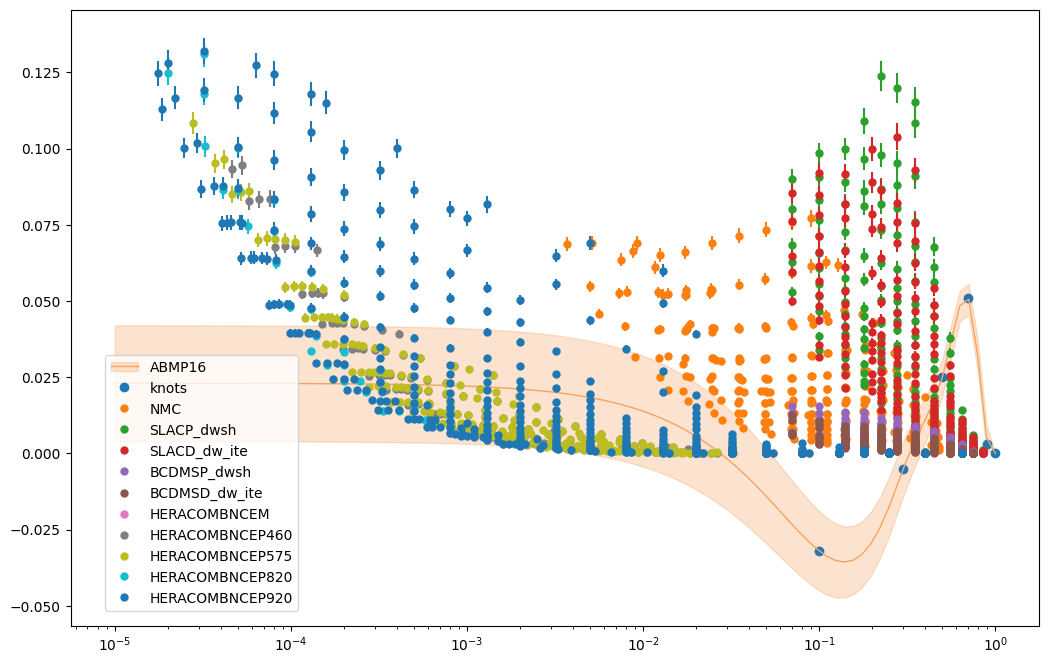

In [23]:
xv = np.logspace(-5, -0.0001, 100)
legends = []
legend_name = ["ABMP16", "knots"]
fig, ax = plt.subplots(figsize=(12.5, 8))
knots = ax.plot(x, y, 'o', label='data')
pl = ax.plot(xv, cs(xv), ls = "-", lw = 1, color=cs_color)
pl_lg= ax.fill(np.NaN, np.NaN, color = cs_color, alpha = 0.3) # Necessary for fancy legend
legends.append((pl[0], pl_lg[0]))
legends.append(knots[0])
ax.fill_between(xv, csp(xv), csm(xv), color = cs_color, alpha = 0.3)
ax.set_xscale("log")

# Plot predictions per data set
for set in preds_ht_posterior.keys():
    #pt = ax.plot(x_for_plot[set], preds_ht_posterior[set], 'o')
    pt = ax.errorbar(x_for_plot[set], preds_ht_posterior[set],
                     yerr=preds_ht_posterior_sigma[set],
                     marker='o',linestyle='None', markersize=5)
    legends.append(pt[0])
    legend_name.append(set)


fig.legend(legends, legend_name, loc=[0.1,0.08], fontsize=10)
plt.show()